In [126]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import shuffle
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error

In [127]:
df_pres = pd.read_csv('df_pres.csv')
df_pres.iloc[len(df_pres)//2]

year                     1991
month                       1
inflation                 5.7
interest                 6.91
unemployment              6.4
CPI                     134.6
senate_pol           0.618786
house_pol            0.658964
approval                 58.0
disapproval              31.0
president       G. H. W. Bush
Name: 1170, dtype: object

In [128]:
Y = df_pres.disapproval.to_numpy()
X = df_pres.drop(['year', 'month', 'approval', 'disapproval', 'president'], axis=1).to_numpy()

#take care of nans
nan_mask = ~np.isnan(Y)
Y = Y[nan_mask]
X = X[nan_mask, :]

#normalize
max_X = np.nanmax(X, axis=0)  
min_X = np.nanmin(X, axis=0)
X = (X-min_X)/(max_X-min_X + 1e-9)
max_Y = np.nanmax(Y, axis=0)
min_Y = np.nanmin(Y, axis=0)
Y = (Y-min_Y)/(max_Y-min_Y + 1e-9)

#shuffle
shuffled_indices = np.random.permutation(len(Y))
X = X[shuffled_indices]
Y = Y[shuffled_indices]

print(X.shape, Y.shape)

(1898, 6) (1898,)


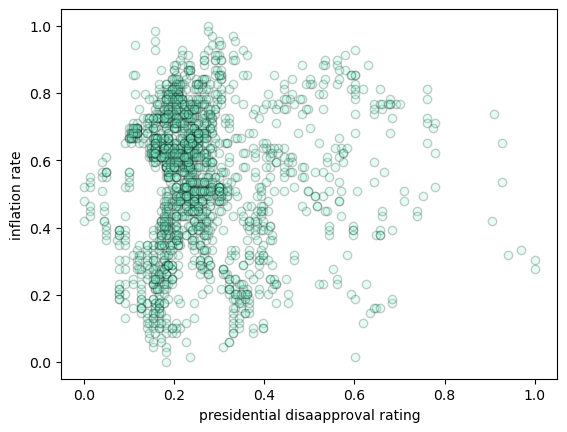

In [129]:
#plot one of the labels
fig, ax = plt.subplots()
ax.scatter(X[:,0], Y, marker = 'o', facecolor = 'aquamarine', edgecolor = 'k', alpha = .2)
ax.set_xlabel('presidential disaapproval rating')
ax.set_ylabel('inflation rate');

In [130]:
#training, validation split
ratio = 4 #training to validation ratio. We don't have that much training data, so let's set the ratio to be high
l = len(Y)
Y_val, Y_train = Y[:l//ratio], Y[l//ratio+1:]
X_val, X_train = X[:l//ratio,:], X[l//ratio+1:,:]

## 1. XGBoost as is.

In [141]:
#use rmse as loss fn
regressor=xgb.XGBRegressor(eval_metric='rmse')

#do a quick grid search for hyperparameters
param_grid = {"max_depth": [4, 5, 6], "n_estimators": [200, 300, 500], "learning_rate": [0.01, 0.015, 0.02]}
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, Y_train)
print(search.best_params_)

{'learning_rate': 0.02, 'max_depth': 6, 'n_estimators': 500}


In [142]:
regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"], n_estimators  = search.best_params_["n_estimators"],\
                           max_depth = search.best_params_["max_depth"], eval_metric='rmse')
regressor.fit(X_train, Y_train)
Y_preds = regressor.predict(X_val)

r-squared = 0.93
mse = 0.0030783235631314377


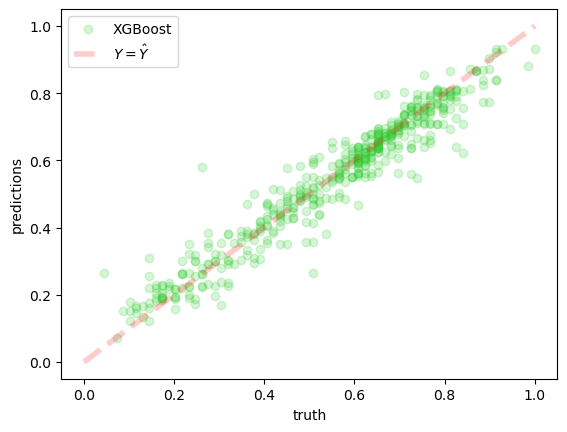

In [143]:
#evaluate
r2 = r2_score(Y_val, Y_preds)
print(f"r-squared = {r2:.2f}")

mse = mean_squared_error(Y_preds, Y_val)
print(f"mse = {mse}")

fig, ax = plt.subplots()
ax.scatter(Y_val, Y_preds, alpha = .2, color = 'limegreen', label = 'XGBoost')
ax.set_xlabel('truth')
ax.set_ylabel('predictions')
ax.plot([0,1], [0,1], alpha = .2, linewidth = 4, color = 'red', linestyle = "--", label = r"$Y=\hat{Y}$")
ax.legend();

What if we took autocorrelation into account? 
## 2. XGBoost with time series cross validator

(1265, 6) (1265,)
Fold r-squared score: 0.21116449324558328
(1265, 6) (1265,)
Fold r-squared score: 0.21700014833091108
(1266, 6) (1266,)
Fold r-squared score: 0.21531042747841178
Average r-squared: 0.2144916896849687


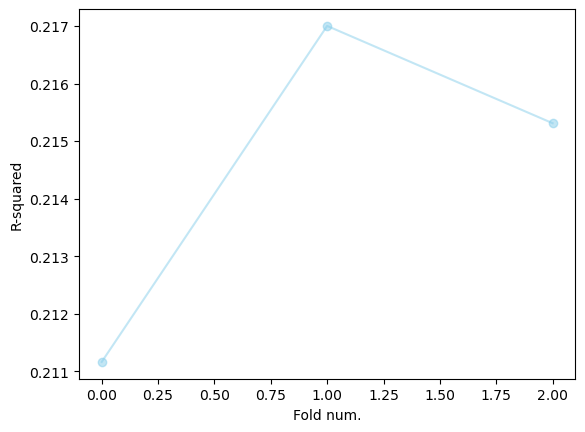

In [171]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
import numpy as np
import matplotlib.pyplot as plt

Y = df_pres.disapproval.to_numpy()
X = df_pres.drop(['year', 'month', 'approval', 'disapproval', 'president'], axis=1).to_numpy()

nan_mask = ~np.isnan(Y)
Y = Y[nan_mask]
X = X[nan_mask, :]

imputer = SimpleImputer(strategy='mean')  
X_imputed = imputer.fit_transform(X)

max_X = np.nanmax(X_imputed, axis=0)  
min_X = np.nanmin(X_imputed, axis=0)
X_normalized = (X_imputed - min_X) / (max_X - min_X + 1e-9)
max_Y = np.nanmax(Y, axis=0)
min_Y = np.nanmin(Y, axis=0)
Y_normalized = (Y - min_Y) / (max_Y - min_Y + 1e-9)

# K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True)
all_r2 = []

# Lasso model
lasso_model = Lasso(alpha=0.01)  

for train_index, test_index in kf.split(X_normalized):
    X_train, X_val = X_normalized[train_index], X_normalized[test_index]
    Y_train, Y_val = Y_normalized[train_index], Y_normalized[test_index]

    print(X_train.shape, Y_train.shape)

    # Fit the Lasso model
    lasso_model.fit(X_train, Y_train)
    Y_val_pred = lasso_model.predict(X_val)

    # Calculate r-squared
    r2 = r2_score(Y_val, Y_val_pred)
    all_r2.append(r2)
    print(f"Fold r-squared score: {r2}")

# Plot the r-squared scores across folds
fig, ax = plt.subplots()
ax.plot(range(len(all_r2)), all_r2, marker='o', linestyle='-', color='skyblue', alpha=.5)
ax.set_xlabel('Fold num.')
ax.set_ylabel('R-squared')
avg_r2 = np.mean(all_r2)
print(f"Average r-squared: {avg_r2}")
